# Sterefog dataset - pix2pix application

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm   # colormap for the rating of the fogginess
import shutil
import os
import random
import cv2
import numpy as np
from skimage.metrics import structural_similarity

from utils_stereofog import variance_of_laplacian

## Using pretrained foggy cityscapes pix2pix model for inference

In [1]:
!python test.py --dataroot ./datasets/first_fog_device_images/B --direction BtoA --model test --name foggy_cityscapes_pix2pix --netG unet_256 --dataset_mode single --norm batch

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/first_fog_device_images/B	[default: None]
             dataset_mode: single                        
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0      

## Moving all subsets of dataset into one folder

In [2]:
path = 'datasets/stereofog_images'

folders = [item for item in os.listdir(path)]

for folder in folders:
    for subfolder in ['A', 'B']:

        if subfolder not in os.listdir(path):
            os.mkdir(path+'/'+subfolder)

        files = [item for item in os.listdir(path+'/'+folder+'/'+subfolder) if item[0] != '.']

        for file in files:
            os.rename(path+'/'+folder+'/'+subfolder+'/'+file, path+'/'+subfolder+'/'+file)

    shutil.rmtree(path+'/'+folder)

## Creating train/test/val splits

In [3]:
path = 'datasets/stereofog_images'

all_files = os.listdir(path + '/A')

random.seed(0)

subset_train = random.sample(all_files, round(len(all_files)*0.8))

remaining = list(set(all_files) - set(subset_train))

subset_val = random.sample(remaining, round(len(remaining)*0.5))

subset_test = list(set(remaining) - set(subset_val))

subfolders = ['/train', '/val', '/test']

for folder in ['/A', '/B']:
	for subfolder, subset in zip (subfolders, [subset_train, subset_val, subset_test]):
		try:
			os.listdir(path + folder + subfolder)
		except:
			os.mkdir(path + folder + subfolder)

		for file in subset:
			file_name = os.path.join(path + folder, file)
			new_file_name = os.path.join(path + folder + subfolder, file)
			os.rename(file_name, new_file_name) # Moving the files from folder (A or B) into subfolder (train, val, test)

In [6]:
!python datasets/combine_A_and_B.py --fold_A datasets/stereofog_images/A --fold_B datasets/stereofog_images/B --fold_AB datasets/stereofog_images

[fold_A] =  datasets/stereofog_images/A
[fold_B] =  datasets/stereofog_images/B
[fold_AB] =  datasets/stereofog_images
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = val, use 506/506 images
split = val, number of images = 506
split = test, use 506/506 images
split = test, number of images = 506
split = train, use 4049/4049 images
split = train, number of images = 4049


In [12]:
!python train.py --dataroot ./datasets/stereofog_images --name stereofog_pix2pix --model pix2pix --direction BtoA --display_id -1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/stereofog_data     	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest          

In [1]:
!python test.py --dataroot ./datasets/stereofog_data --direction BtoA --model pix2pix --name stereofog_pix2pix

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/stereofog_data     	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0            

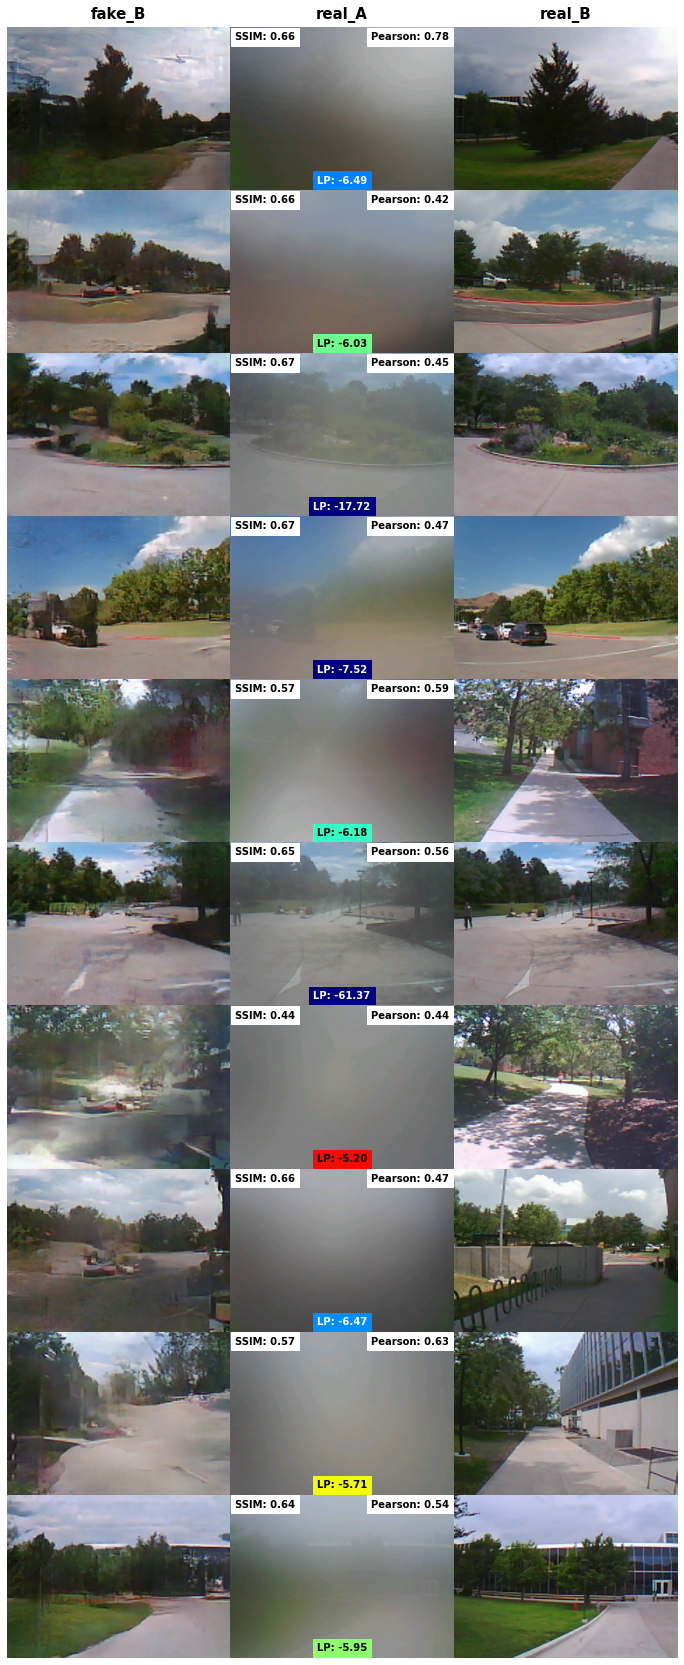

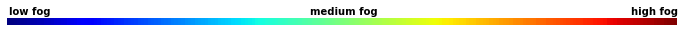

In [9]:
results_path = './results/stereofog_pix2pix/test_latest/images/'

min_fog_value_limit = -7
max_fog_value_limit = -5
center_fog_value_limit = min_fog_value_limit + (max_fog_value_limit - min_fog_value_limit)*0.4
norm = matplotlib.colors.Normalize(vmin=min_fog_value_limit, vmax=max_fog_value_limit)    # Normalizer for the values of the colormap rating the fogginess of the image: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib

images = [entry for entry in os.listdir(results_path) if 'fake_B' in entry]
random.seed(16)
random.shuffle(images)

limit = 10

os.listdir('./datasets/stereofog_data/A/test')[0]

orig_img = plt.imread('./datasets/stereofog_data/A/test/2023-08-01-04__20.bmp')

ratio = orig_img.shape[1]/orig_img.shape[0]

width_per_image = 4
height_per_image = width_per_image / ratio

fig = plt.figure(figsize=(3*width_per_image,limit*height_per_image))

ax = [fig.add_subplot(limit,3,i+1) for i in range(limit*3)]

ax[0].text(0.5, 1.05, 'fake_B', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[0].transAxes)
ax[1].text(0.5, 1.05, 'real_A', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[1].transAxes)
ax[2].text(0.5, 1.05, 'real_B', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[2].transAxes)

# fig, ax = plt.subplots(limit,3)
for i in range(limit):
    # plt.subplot(limit,3,1+3*i)
    # plt.title('fake_B')
    img1 = plt.imread(results_path + images[i])
    ax[3*i].imshow(img1, aspect='auto')
    ax[3*i].axis('off')
    # plt.subplot(limit,3,2+3*i)
    # plt.title('real_A')
    img2 = plt.imread(results_path + images[i][:-10] + 'real_A' + '.png')
    ax[1+3*i].imshow(img2, aspect='auto')

    # Reading in the fogged image and calculating the variance of the Laplacian
    fogged_image_gray = cv2.cvtColor(cv2.imread(results_path + images[i][:-10] + 'real_A' + '.png'), cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(fogged_image_gray)

    ax[1+3*i].text(0.5,0.03, f'Laplace: {fm:.2f}', transform=ax[1+3*i].transAxes, backgroundcolor=cm.jet(norm(fm)), horizontalalignment='center', verticalalignment='bottom', fontweight='black', color='k' if fm > center_fog_value_limit else 'w')
    ax[1+3*i].axis('off')
    # plt.subplot(limit,3,3+3*i)
    # plt.title('real_B')
    img3 = plt.imread(results_path + images[i][:-10] + 'real_B' + '.png')
    ax[2+3*i].imshow(img3, aspect='auto')
    ax[2+3*i].axis('off')

    # Reading in the clear image and calculating the SSIM to get a value for the fogginess (how much the fog changes the image) (https://stackoverflow.com/questions/71567315/how-to-get-the-ssim-comparison-score-between-two-images)
    clear_image_gray = cv2.cvtColor(cv2.imread(results_path + images[i][:-10] + 'real_B' + '.png'), cv2.COLOR_BGR2GRAY)

    (SSIM_score, SSIM_diff) = structural_similarity(img3, img2, full=True, multichannel=True)
    ax[1+3*i].text(0.02,0.91, f'SSIM: {SSIM_score:.2f}', transform=ax[1+3*i].transAxes, backgroundcolor='w', horizontalalignment='left', verticalalignment='bottom', fontweight='black', color='k')

    # Calculating the Pearson correlation coefficient between the two images (https://stackoverflow.com/questions/34762661/percentage-difference-between-two-images-in-python-using-correlation-coefficient, https://mbrow20.github.io/mvbrow20.github.io/PearsonCorrelationPixelAnalysis.html)
    Pearson_image_correlation = np.corrcoef(np.asarray(fogged_image_gray), np.asarray(clear_image_gray))
    corrImAbs = np.absolute(Pearson_image_correlation)

    ax[1+3*i].text(0.98,0.91, f'Pearson: {np.mean(corrImAbs):.2f}', transform=ax[1+3*i].transAxes, backgroundcolor='w', horizontalalignment='right', verticalalignment='bottom', fontweight='black', color='k')


# plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0, wspace=0)
# plt.tight_layout()

plt.show()

# pLotting the colormap below (https://stackoverflow.com/questions/2451264/creating-a-colormap-legend-in-matplotlib)
m = np.zeros((1,200))
for i in range(200):
    m[0,i] = (i)/200.0


fig, ax = plt.subplots(figsize=(3*width_per_image, 0.2))

plt.imshow(m, cmap='jet', aspect = 2)
plt.yticks(np.arange(0))

ax.axis('off')

for coordinate, text, ha in zip([0, 100, 200], ['low fog', 'medium fog', 'high fog'], ['left', 'center', 'right']):
    plt.text(coordinate, -0.7, text, ha=ha, va='bottom', fontweight='black', color='k')


plt.show()

In [ ]:
results_path = './results/stereofog_pix2pix/test_latest/images/'

min_fog_value_limit = -7
max_fog_value_limit = -5
center_fog_value_limit = min_fog_value_limit + (max_fog_value_limit - min_fog_value_limit)*0.4
norm = matplotlib.colors.Normalize(vmin=min_fog_value_limit, vmax=max_fog_value_limit)    # Normalizer for the values of the colormap rating the fogginess of the image: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib

images = [entry for entry in os.listdir(results_path) if 'fake_B' in entry]
random.seed(16)
random.shuffle(images)

limit = 10

os.listdir('./datasets/stereofog_data/A/test')[0]

orig_img = plt.imread('./datasets/stereofog_data/A/test/2023-08-01-04__20.bmp')

ratio = orig_img.shape[1]/orig_img.shape[0]

width_per_image = 4
height_per_image = width_per_image / ratio

fig = plt.figure(figsize=(3*width_per_image,limit*height_per_image))

ax = [fig.add_subplot(limit,3,i+1) for i in range(limit*3)]

ax[0].text(0.5, 1.05, 'fake_B', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[0].transAxes)
ax[1].text(0.5, 1.05, 'real_A', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[1].transAxes)
ax[2].text(0.5, 1.05, 'real_B', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[2].transAxes)

# fig, ax = plt.subplots(limit,3)
for i in range(limit):
    # plt.subplot(limit,3,1+3*i)
    # plt.title('fake_B')
    img1 = plt.imread(results_path + images[i])
    ax[3*i].imshow(img1, aspect='auto')
    ax[3*i].axis('off')
    # plt.subplot(limit,3,2+3*i)
    # plt.title('real_A')
    img2 = plt.imread(results_path + images[i][:-10] + 'real_A' + '.png')
    ax[1+3*i].imshow(img2, aspect='auto')

    # Reading in the fogged image and calculating the variance of the Laplacian
    fogged_image_gray = cv2.cvtColor(cv2.imread(results_path + images[i][:-10] + 'real_A' + '.png'), cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(fogged_image_gray)

    ax[1+3*i].text(0.5,0.03, f'LP: {fm:.2f}', transform=ax[1+3*i].transAxes, backgroundcolor=cm.jet(norm(fm)), horizontalalignment='center', verticalalignment='bottom', fontweight='black', color='k' if fm > center_fog_value_limit else 'w')
    ax[1+3*i].axis('off')
    # plt.subplot(limit,3,3+3*i)
    # plt.title('real_B')
    img3 = plt.imread(results_path + images[i][:-10] + 'real_B' + '.png')
    ax[2+3*i].imshow(img3, aspect='auto')
    ax[2+3*i].axis('off')

    # Reading in the clear image and calculating the SSIM to get a value for the fogginess (how much the fog changes the image) (https://stackoverflow.com/questions/71567315/how-to-get-the-ssim-comparison-score-between-two-images)
    clear_image_gray = cv2.cvtColor(cv2.imread(results_path + images[i][:-10] + 'real_B' + '.png'), cv2.COLOR_BGR2GRAY)

    (SSIM_score, SSIM_diff) = structural_similarity(fogged_image_gray, clear_image_gray, full=True)
    ax[1+3*i].text(0.02,0.91, f'SSIM: {SSIM_score:.2f}', transform=ax[1+3*i].transAxes, backgroundcolor='w', horizontalalignment='left', verticalalignment='bottom', fontweight='black', color='k')



# plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0, wspace=0)
# plt.tight_layout()

plt.show()

# pLotting the colormap below (https://stackoverflow.com/questions/2451264/creating-a-colormap-legend-in-matplotlib)
m = np.zeros((1,200))
for i in range(200):
    m[0,i] = (i)/200.0


fig, ax = plt.subplots(figsize=(3*width_per_image, 0.2))

plt.imshow(m, cmap='jet', aspect = 2)
plt.yticks(np.arange(0))

ax.axis('off')

for coordinate, text, ha in zip([0, 100, 200], ['low fog', 'medium fog', 'high fog'], ['left', 'center', 'right']):
    plt.text(coordinate, -0.7, text, ha=ha, va='bottom', fontweight='black', color='k')


plt.show()